In [16]:
import pandas as pd
import tensorflow as tf
import numpy as np

df = pd.read_excel("./PV0_48h_inizio.xlsx")


In [17]:
import random
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [18]:
import re
df_ = df.copy()

col1 = 'Contatore 2 Energia Attiva Immessa (K=500) [Wh]'
col2 = 'Contatore 1 Energia Attiva Immessa (K=500) [Wh]'

# Somma delle due colonne
df_['Energia Attiva Immessa (Contatore 1 + 2) [Wh]'] = df_[col1] + df_[col2]

target_col = 'Energia Attiva Immessa (Contatore 1 + 2) [Wh]'

regex_pattern = r'^Inverter\s[\d\.]+\sCorrente DC \[A\]$'
regex_pattern2 = r'^Inverter\s[\d\.]+\s(Corrente (AC|DC) \[A\]|Energia Attiva \[Wh\]|Potenza Attiva \[W\]|Temperatura Inverter \[ºC\]|Tensione AC \[V\])$'



feature_col = [col for col in df.columns if re.match(regex_pattern2, col)]

pca_columns = [
    #'Solarimetro Cabina 1 Temperatura Moduli [ºC]',
    #'Solarimetro Cabina 2 Temperatura Moduli [ºC]',
    #'Piranometro 1 Irraggiamento [W/mq]',
    #'Piranometro 2 Irraggiamento [W/mq]',
    #'Piranometro 2 Irraggiamento-Irradiation [Wh/mq]',
    #'Piranometro 3 Irraggiamento [W/mq]',
    'Solarimetro Cabina 1 Irraggiamento [W/mq]',
    'Solarimetro Cabina 1 Irraggiamento-Irradiation [Wh/mq]',
    'Solarimetro Cabina 2 Irraggiamento [W/mq]',
    'Solarimetro Cabina 2 Irraggiamento-Irradiation [Wh/mq]',
    ]

columns_to_keep = [
    'Date',
    'anomalia',
] + feature_col + pca_columns + [target_col]

data = df_[columns_to_keep]

data = data[(data['Date'].dt.hour >= 8) & (data['Date'].dt.hour <= 18)]

data = data[~(data == 0).all(axis=1)]

data.columns.tolist()

['Date',
 'anomalia',
 'Inverter 01.01.01 Corrente AC [A]',
 'Inverter 01.01.01 Corrente DC [A]',
 'Inverter 01.01.01 Energia Attiva [Wh]',
 'Inverter 01.01.01 Potenza Attiva [W]',
 'Inverter 01.01.01 Temperatura Inverter [ºC]',
 'Inverter 01.01.01 Tensione AC [V]',
 'Inverter 01.01.02 Corrente AC [A]',
 'Inverter 01.01.02 Corrente DC [A]',
 'Inverter 01.01.02 Energia Attiva [Wh]',
 'Inverter 01.01.02 Potenza Attiva [W]',
 'Inverter 01.01.02 Temperatura Inverter [ºC]',
 'Inverter 01.01.02 Tensione AC [V]',
 'Inverter 01.01.03 Corrente AC [A]',
 'Inverter 01.01.03 Corrente DC [A]',
 'Inverter 01.01.03 Energia Attiva [Wh]',
 'Inverter 01.01.03 Potenza Attiva [W]',
 'Inverter 01.01.03 Temperatura Inverter [ºC]',
 'Inverter 01.01.03 Tensione AC [V]',
 'Inverter 01.01.04 Corrente AC [A]',
 'Inverter 01.01.04 Corrente DC [A]',
 'Inverter 01.01.04 Energia Attiva [Wh]',
 'Inverter 01.01.04 Potenza Attiva [W]',
 'Inverter 01.01.04 Temperatura Inverter [ºC]',
 'Inverter 01.01.04 Tensione AC [V]'

In [19]:
data['month'] = data['Date'].dt.month
data['time'] = data['Date'].dt.time

target_columns = data.columns[data.isna().any()].drop(['month', 'time', 'anomalia'], errors='ignore')

def fill_nan_by_group(col):
    return data.groupby(['month', 'time', 'anomalia'])[col].transform(lambda x: x.fillna(x.mean()))

for col in target_columns:
    data[col] = fill_nan_by_group(col)

data.drop(columns=['month', 'time'], inplace=True)

In [20]:
data.columns.tolist()

['Date',
 'anomalia',
 'Inverter 01.01.01 Corrente AC [A]',
 'Inverter 01.01.01 Corrente DC [A]',
 'Inverter 01.01.01 Energia Attiva [Wh]',
 'Inverter 01.01.01 Potenza Attiva [W]',
 'Inverter 01.01.01 Temperatura Inverter [ºC]',
 'Inverter 01.01.01 Tensione AC [V]',
 'Inverter 01.01.02 Corrente AC [A]',
 'Inverter 01.01.02 Corrente DC [A]',
 'Inverter 01.01.02 Energia Attiva [Wh]',
 'Inverter 01.01.02 Potenza Attiva [W]',
 'Inverter 01.01.02 Temperatura Inverter [ºC]',
 'Inverter 01.01.02 Tensione AC [V]',
 'Inverter 01.01.03 Corrente AC [A]',
 'Inverter 01.01.03 Corrente DC [A]',
 'Inverter 01.01.03 Energia Attiva [Wh]',
 'Inverter 01.01.03 Potenza Attiva [W]',
 'Inverter 01.01.03 Temperatura Inverter [ºC]',
 'Inverter 01.01.03 Tensione AC [V]',
 'Inverter 01.01.04 Corrente AC [A]',
 'Inverter 01.01.04 Corrente DC [A]',
 'Inverter 01.01.04 Energia Attiva [Wh]',
 'Inverter 01.01.04 Potenza Attiva [W]',
 'Inverter 01.01.04 Temperatura Inverter [ºC]',
 'Inverter 01.01.04 Tensione AC [V]'

In [21]:
train_size = 0.70
val_size = 0.15
test_size = 0.15

assert abs(train_size + val_size + test_size - 1.0) < 1e-6

n = len(data)

n_train = int(n * train_size)
n_val = int(n * val_size)
n_test = n - n_train - n_val

# Split progressivo
train = data.iloc[:n_train]
val = data.iloc[n_train:n_train + n_val]
test = data.iloc[n_train + n_val:]

# Reset anche per test (non filtrato)
test = test.reset_index()
test_indices = test['index']

# Split X (feature) e y (target/anomalia)
X_train = train.drop(columns=["anomalia"])
X_val = val.drop(columns=["anomalia", "Date"])
X_test = test.drop(columns=["anomalia", "Date", "index"])

# Indici originali del test set
indices = X_test.index


X_train.columns.tolist()

['Date',
 'Inverter 01.01.01 Corrente AC [A]',
 'Inverter 01.01.01 Corrente DC [A]',
 'Inverter 01.01.01 Energia Attiva [Wh]',
 'Inverter 01.01.01 Potenza Attiva [W]',
 'Inverter 01.01.01 Temperatura Inverter [ºC]',
 'Inverter 01.01.01 Tensione AC [V]',
 'Inverter 01.01.02 Corrente AC [A]',
 'Inverter 01.01.02 Corrente DC [A]',
 'Inverter 01.01.02 Energia Attiva [Wh]',
 'Inverter 01.01.02 Potenza Attiva [W]',
 'Inverter 01.01.02 Temperatura Inverter [ºC]',
 'Inverter 01.01.02 Tensione AC [V]',
 'Inverter 01.01.03 Corrente AC [A]',
 'Inverter 01.01.03 Corrente DC [A]',
 'Inverter 01.01.03 Energia Attiva [Wh]',
 'Inverter 01.01.03 Potenza Attiva [W]',
 'Inverter 01.01.03 Temperatura Inverter [ºC]',
 'Inverter 01.01.03 Tensione AC [V]',
 'Inverter 01.01.04 Corrente AC [A]',
 'Inverter 01.01.04 Corrente DC [A]',
 'Inverter 01.01.04 Energia Attiva [Wh]',
 'Inverter 01.01.04 Potenza Attiva [W]',
 'Inverter 01.01.04 Temperatura Inverter [ºC]',
 'Inverter 01.01.04 Tensione AC [V]',
 'Inverter 

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_features = X_train.drop(columns="Date")
X_val_features = X_val
X_test_features = X_test

train_scaled = pd.DataFrame(scaler.fit_transform(X_train_features), columns=X_train_features.columns, index=X_train.index)
val_scaled = pd.DataFrame(scaler.transform(X_val_features), columns=X_val_features.columns, index=X_val.index)
test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=test_indices)

train_scaled_k = train_scaled.drop(columns=feature_col + [target_col])
val_scaled_k = val_scaled.drop(columns=feature_col + [target_col])
test_scaled_k = test_scaled.drop(columns=feature_col + [target_col])

In [23]:
nan_per_column = train_scaled_k.isna().sum()
print(nan_per_column[nan_per_column > 0])

Series([], dtype: int64)


In [24]:
from sklearn.decomposition import PCA

n_components = 2
pca = PCA(n_components=n_components)
train_pca = pca.fit_transform(train_scaled_k)
val_pca = pca.transform(val_scaled_k)
test_pca = pca.transform(test_scaled_k)

pca.explained_variance_ratio_.sum()

np.float64(0.9856221963778362)

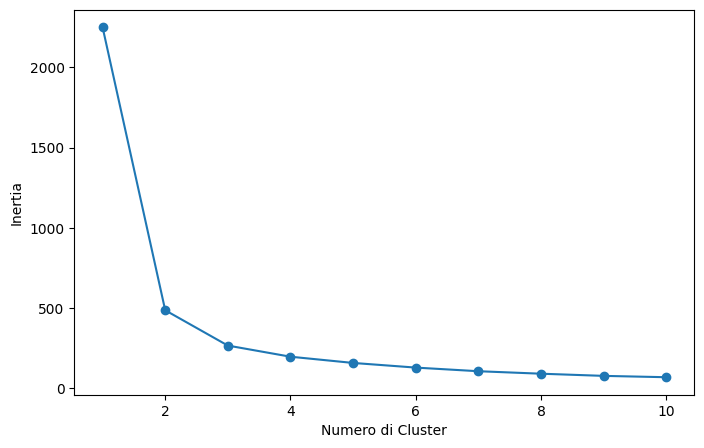

In [25]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(train_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Numero di Cluster')
plt.ylabel('Inertia')
plt.title('')
plt.show()

In [26]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels_train = kmeans.fit_predict(train_pca)
centroids = kmeans.cluster_centers_

# Distanze train
distances_train = np.linalg.norm(train_pca - centroids[cluster_labels_train], axis=1)

# DataFrame train con cluster e distanza
train_clustered = pd.DataFrame(train_pca, columns=[f'PC{i+1}' for i in range(train_pca.shape[1])])
train_clustered['Cluster'] = cluster_labels_train

train_scaled_df = pd.DataFrame(train_scaled, columns=train_scaled.columns)

train_scaled_df['Cluster'] = cluster_labels_train


# Val
cluster_labels_val = kmeans.predict(val_pca)
distances_val = np.linalg.norm(val_pca - centroids[cluster_labels_val], axis=1)
val_clustered = pd.DataFrame(val_pca, columns=[f'PC{i+1}' for i in range(val_pca.shape[1])])
val_clustered['Cluster'] = cluster_labels_val

val_scaled_df = pd.DataFrame(val_scaled, columns=val_scaled.columns)

val_scaled_df['Cluster'] = cluster_labels_val

# Test
cluster_labels_test = kmeans.predict(test_pca)
distances_test = np.linalg.norm(test_pca - centroids[cluster_labels_test], axis=1)
test_clustered = pd.DataFrame(test_pca, columns=[f'PC{i+1}' for i in range(test_pca.shape[1])])
test_clustered['Cluster'] = cluster_labels_test

test_scaled_df = test_scaled.copy()
test_scaled_df['Cluster'] = cluster_labels_test

In [27]:
train_scaled_df = train_scaled_df.copy()
train_scaled_df[feature_col] = train_scaled[feature_col]
train_scaled_df[target_col] = train_scaled[target_col]

val_scaled_df = val_scaled_df.copy()
val_scaled_df[feature_col] = val_scaled[feature_col]
val_scaled_df[target_col] = val_scaled[target_col]

test_scaled_df = test_scaled_df.copy()
test_scaled_df[feature_col] = test_scaled[feature_col]
test_scaled_df[target_col] = test_scaled[target_col]

test_scaled_df.head()


,Inverter 01.01.01 Corrente AC [A],Inverter 01.01.01 Corrente DC [A],Inverter 01.01.01 Energia Attiva [Wh],Inverter 01.01.01 Potenza Attiva [W],Inverter 01.01.01 Temperatura Inverter [ºC],Inverter 01.01.01 Tensione AC [V],Inverter 01.01.02 Corrente AC [A],Inverter 01.01.02 Corrente DC [A],Inverter 01.01.02 Energia Attiva [Wh],Inverter 01.01.02 Potenza Attiva [W],...,Inverter 02.06.06 Energia Attiva [Wh],Inverter 02.06.06 Potenza Attiva [W],Inverter 02.06.06 Temperatura Inverter [ºC],Inverter 02.06.06 Tensione AC [V],Solarimetro Cabina 1 Irraggiamento [W/mq],Solarimetro Cabina 1 Irraggiamento-Irradiation [Wh/mq],Solarimetro Cabina 2 Irraggiamento [W/mq],Solarimetro Cabina 2 Irraggiamento-Irradiation [Wh/mq],Energia Attiva Immessa (Contatore 1 + 2) [Wh],Cluster
index,,,,,,,,,,,,,,,,,,,,,
32194,0.841279,0.873498,0.0,0.845809,0.730204,0.968318,0.851586,0.797642,0.0,0.841762,...,0.0,0.534210,0.615691,0.965329,0.645980,0.327062,0.709895,0.428144,0.0,0
32195,0.859144,0.884687,0.0,0.868605,0.756636,0.973264,0.880343,0.825860,0.0,0.871307,...,0.0,0.557076,0.646206,0.966550,0.665021,0.348672,0.725637,0.454517,0.0,0
32196,0.877198,0.908827,0.0,0.887991,0.772216,0.972137,0.898267,0.846927,0.0,0.890520,...,0.0,0.575981,0.667850,0.971463,0.679831,0.345921,0.735382,0.447385,0.0,0
32197,0.881241,0.913800,0.0,0.891581,0.786406,0.972356,0.899941,0.860359,0.0,0.894508,...,0.0,0.593986,0.690568,0.972151,0.691819,0.365208,0.745877,0.469509,0.0,0
32198,0.887917,0.935557,0.0,0.895889,0.802265,0.971730,0.906933,0.872922,0.0,0.899946,...,0.0,0.603709,0.702667,0.966425,0.700282,0.358079,0.748126,0.457493,0.0,0


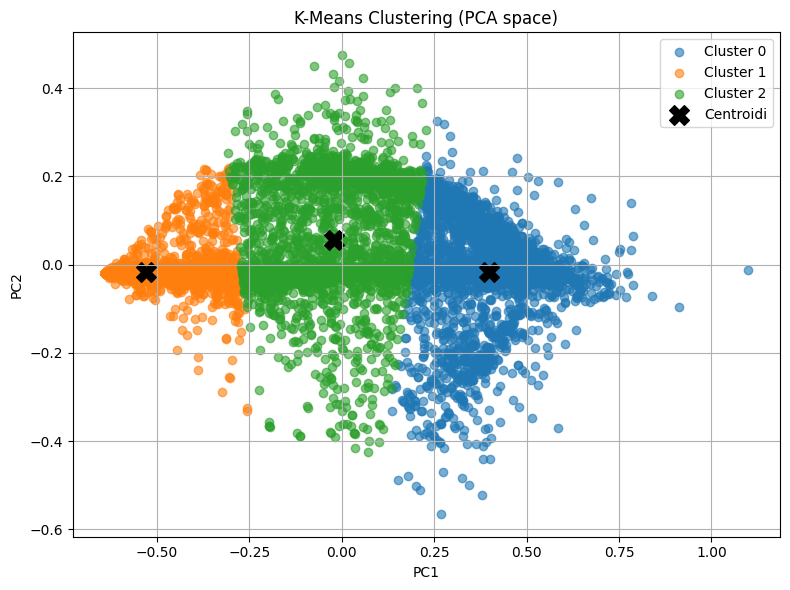

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for cluster_id in range(n_clusters):
    cluster_points = train_clustered[train_clustered['Cluster'] == cluster_id]
    plt.scatter(
        cluster_points['PC1'],
        cluster_points['PC2'],
        label=f'Cluster {cluster_id}',
        alpha=0.6
    )

centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    s=200, c='black', marker='X', label='Centroidi'
)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering (PCA space)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
def create_sliding_data(df, cluster_id, window_size, target_col):
    cluster_df = df[df['Cluster'] == cluster_id].copy()
    cluster_df = cluster_df.sort_index()

    if len(cluster_df) <= window_size:
        print(f"Cluster {cluster_id} ha solo {len(cluster_df)} righe, troppo poche per window_size = {window_size}.")
        return np.array([]), np.array([])

    X, y = [], []

    feature_data = cluster_df.drop(columns=["Cluster"]).values
    target_values = cluster_df[target_col].values

    for i in range(len(feature_data) - window_size):
        X.append(feature_data[i:i+window_size])
        y.append(target_values[i + window_size])

    return np.array(X), np.array(y)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

def build_lstm(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mae')
    return model

window_size = 36
cluster_models = {}

for cluster_id in range(3):
    print(f"\n Addestramento modello per cluster {cluster_id}")

    X_train, y_train = create_sliding_data(train_scaled_df, cluster_id, window_size, target_col)
    X_val, y_val = create_sliding_data(val_scaled_df, cluster_id, window_size, target_col)

    print(X_train.shape, X_val.shape)

    model = build_lstm((X_train.shape[1], X_train.shape[2]))

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=16,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    cluster_models[cluster_id] = model



 Addestramento modello per cluster 0
(5392, 36, 221) (1527, 36, 221)
Epoch 1/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1518 - val_loss: 0.0177 - learning_rate: 0.0010
Epoch 2/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0477 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 3/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0426 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 4/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0596 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 5/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0411 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 6/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0348 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0380 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 8/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0356 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 9/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/ste

In [31]:
from sklearn.metrics import mean_squared_error
import numpy as np

results = {}
mse_list = []
dynamic_thresholds = {}


for cluster_id in range(3):
    print(f"\n📈 Predizione per cluster {cluster_id}")

    X_val_cluster, y_val_cluster = create_sliding_data(val_scaled_df, cluster_id, window_size, target_col)

    X_test, y_test = create_sliding_data(test_scaled_df, cluster_id, window_size, target_col)

    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)


    if len(X_test) == 0:
        print(f"Nessun dato nel cluster {cluster_id} nel test set.")
        continue

    y_pred = cluster_models[cluster_id].predict(X_test)
    results[cluster_id] = (y_test, y_pred)

    y_test = np.array(y_test).flatten()
    y_pred = np.array(y_pred).reshape(-1)
    mse = mean_squared_error(y_test, y_pred)

    mse_list.append(mse)

    print(f"MSE per cluster {cluster_id}: {mse:.4f}")

    if len(X_val_cluster) > 0:
        y_val_pred = cluster_models[cluster_id].predict(X_val_cluster)
        val_errors = (y_val_cluster - y_val_pred.flatten()) ** 2

        threshold = np.mean(val_errors) + 3 * np.std(val_errors)

        dynamic_thresholds[cluster_id] = threshold
        print(f"➡️ Soglia dinamica (cluster {cluster_id}): {threshold:.6f}")
    else:
        print(f"⚠️ Nessun dato nel cluster {cluster_id} nel validation set.")
        dynamic_thresholds[cluster_id] = None



📈 Predizione per cluster 0
X_test shape: (1898, 36, 221)
y_test shape: (1898,)
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE per cluster 0: 0.0005
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
➡️ Soglia dinamica (cluster 0): 0.000030

📈 Predizione per cluster 1
X_test shape: (232, 36, 221)
y_test shape: (232,)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MSE per cluster 1: 0.0000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
➡️ Soglia dinamica (cluster 1): 0.000016

📈 Predizione per cluster 2
X_test shape: (366, 36, 221)
y_test shape: (366,)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MSE per cluster 2: 0.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
➡️ Soglia dinamica (cluster 2): 0.000234


  Cluster 0:
   Totale elementi:         1898
   Anomalie reali (SI):     363
   Anomalie identificate:   233

  Cluster 1:
   Totale elementi:         232
   Anomalie reali (SI):     66
   Anomalie identificate:   66

  Cluster 2:
   Totale elementi:         366
   Anomalie reali (SI):     66
   Anomalie identificate:   17


=== METRICHE GLOBALI ===

[[1817  184]
 [ 363  132]]
              precision    recall  f1-score   support

      Normal       0.83      0.91      0.87      2001
     Anomaly       0.42      0.27      0.33       495

    accuracy                           0.78      2496
   macro avg       0.63      0.59      0.60      2496
weighted avg       0.75      0.78      0.76      2496


Accuracy globale: 0.7808
Precision globale: 0.4177
Recall globale: 0.2667
F1-score globale: 0.3255


C:\Users\immed\AppData\Local\Temp\ipykernel_11804\712467806.py:90: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_scaled_df['Date'] = df_.loc[test_scaled_df.index, 'Date'].values


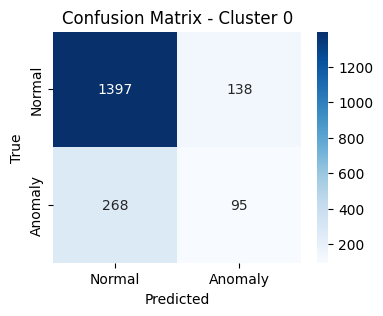

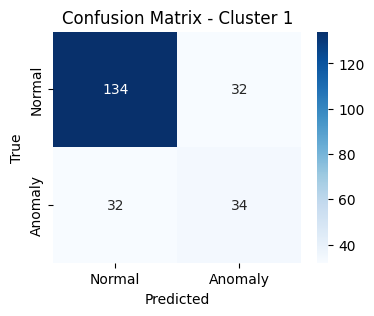

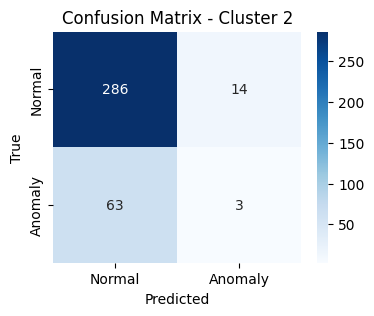

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

tresholds = {
    0: 0.0000055,
    1: 0.0000003,
    2: 0.00005,
    3: 0.00003,
    4: 0.00001
}

all_y_true = []
all_y_pred = []

cluster_metrics = {}

for cluster_id in range(3):
    if cluster_id not in results:
        continue

    y_true, y_pred = results[cluster_id]

    treshold = tresholds[cluster_id]
    squared_errors = (y_true - y_pred.flatten())**2
    predicted_anomalies = (squared_errors > treshold).astype(int)
    
    test_cluster_df = test_scaled_df[test_scaled_df['Cluster'] == cluster_id].copy()
    indices = test_cluster_df.index
    n_preds = len(predicted_anomalies)
    aligned_indices = indices[-n_preds:]

    y_true_labels = df.loc[aligned_indices, 'anomalia'].values
    label_map = {'NO': 0, 'SI': 1}
    y_true_numeric = [label_map[label] for label in y_true_labels]

    num_anomalies_pred = np.sum(predicted_anomalies)
    num_anomalies_real = np.sum(np.array(y_true_numeric))
    support = len(y_true_numeric)

    print(f"  Cluster {cluster_id}:")
    print(f"   Totale elementi:         {support}")
    print(f"   Anomalie reali (SI):     {num_anomalies_real}")
    print(f"   Anomalie identificate:   {num_anomalies_pred}\n")

    acc = accuracy_score(y_true_numeric, predicted_anomalies)
    prec = precision_score(y_true_numeric, predicted_anomalies, zero_division=0)
    rec = recall_score(y_true_numeric, predicted_anomalies, zero_division=0)
    f1 = f1_score(y_true_numeric, predicted_anomalies, zero_division=0)

    cluster_metrics[cluster_id] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    }

    all_y_true.extend(y_true_numeric)
    all_y_pred.extend(predicted_anomalies)

print("\n=== METRICHE GLOBALI ===\n")
print(confusion_matrix(all_y_true, all_y_pred))
print(classification_report(all_y_true, all_y_pred, target_names=["Normal", "Anomaly"]))

accuracy = accuracy_score(all_y_true, all_y_pred)
precision = precision_score(all_y_true, all_y_pred)
recall = recall_score(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred)

print(f"\nAccuracy globale: {accuracy:.4f}")
print(f"Precision globale: {precision:.4f}")
print(f"Recall globale: {recall:.4f}")
print(f"F1-score globale: {f1:.4f}")

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
cluster_ids = list(cluster_metrics.keys())

data = {metric: [cluster_metrics[cid][metric] for cid in cluster_ids] for metric in metric_names}

for cluster_id in range(3):
    if cluster_id not in results:
        continue

    y_true, y_pred = results[cluster_id]

    treshold = tresholds[cluster_id]
    squared_errors = (y_true - y_pred.flatten())**2
    predicted_anomalies = (squared_errors > treshold).astype(int)
    test_scaled_df['Date'] = df_.loc[test_scaled_df.index, 'Date'].values
    test_cluster_df = test_scaled_df[test_scaled_df['Cluster'] == cluster_id].copy()
    indices = test_cluster_df.index
    n_preds = len(predicted_anomalies)
    aligned_indices = indices[-n_preds:]

    y_true_labels = df.loc[aligned_indices, 'anomalia'].values
    label_map = {'NO': 0, 'SI': 1}
    y_true_numeric = [label_map[label] for label in y_true_labels]

    cm = confusion_matrix(y_true_numeric, predicted_anomalies)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.title(f'Confusion Matrix - Cluster {cluster_id}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



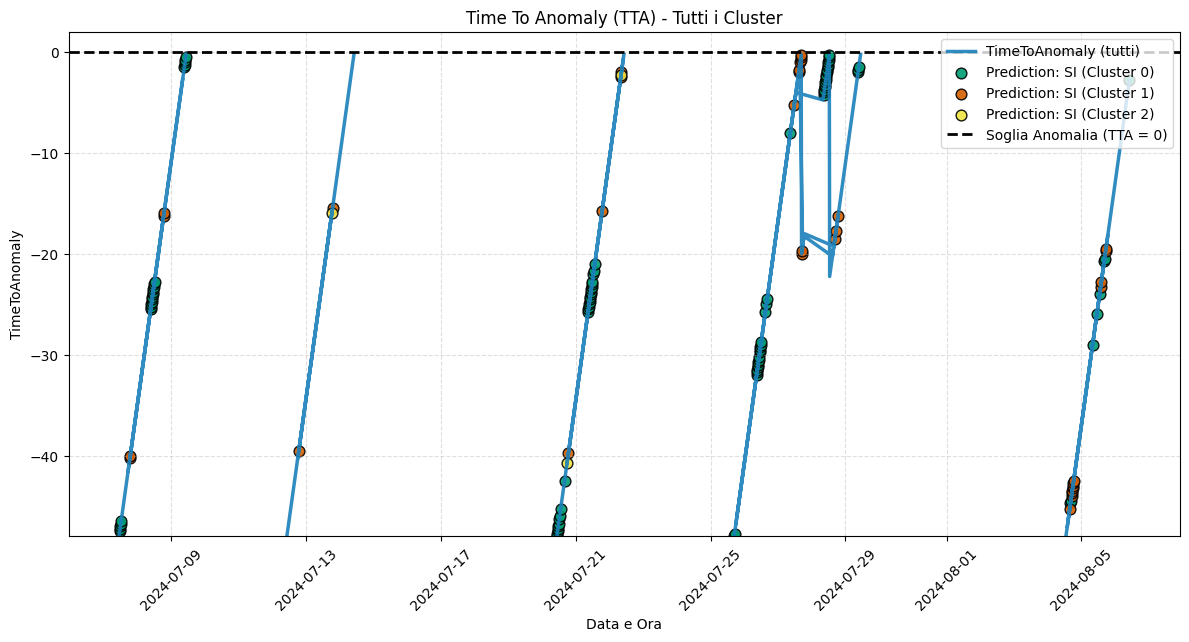

In [33]:
tta_all = []
tta_pos = []
tta_fp = []

for cluster_id in range(3):
    if cluster_id not in results:
        continue

    y_true, y_pred = results[cluster_id]
    squared_errors = (y_true - y_pred.flatten())**2

    treshold = tresholds[cluster_id]
    predicted_anomalies = (squared_errors > treshold).astype(int)

    test_cluster_df = test_scaled_df[test_scaled_df['Cluster'] == cluster_id].copy()
    indices = test_cluster_df.index
    n_preds = len(predicted_anomalies)
    aligned_indices = indices[-n_preds:]

    df_pred_context = df.loc[aligned_indices].copy()
    df_pred_context['prediction'] = predicted_anomalies
    df_pred_context['TimeToAnomaly'] = df_pred_context['anomalia_1'].astype(float)
    df_pred_context['Cluster'] = cluster_id

    df_fp = df_pred_context[(df_pred_context['prediction'] == 1) &
                            (df_pred_context['anomalia_1'].isna())]
    tta_fp.append(df_fp[['Date', 'TimeToAnomaly', 'Cluster']])

    df_positive = df_pred_context[df_pred_context['prediction'] == 1]
    tta_pos.append(df_positive[['Date', 'TimeToAnomaly', 'Cluster']])

    tta_all.append(df_pred_context[['Date', 'TimeToAnomaly']])

tta_all_df = pd.concat(tta_all)
tta_pos_df = pd.concat(tta_pos)
fp_df = pd.concat(tta_fp, ignore_index=True)

plt.figure(figsize=(12, 6))

plt.plot(tta_all_df['Date'],
         tta_all_df['TimeToAnomaly'],
         label='TimeToAnomaly (tutti)',
         color="#1A80BB",
         linewidth=2.5,
         alpha=0.9)

cluster_colors = {
    0: '#009E73',
    1: '#D55E00',
    2: '#F0E442',
}

for cluster_id, color in cluster_colors.items():
    df_cluster_pos = tta_pos_df[tta_pos_df['Cluster'] == cluster_id]

    if df_cluster_pos.empty:
        plt.scatter([], [], color=color, label=f'Prediction: SI (Cluster {cluster_id})')
        continue

    plt.scatter(df_cluster_pos['Date'],
                df_cluster_pos['TimeToAnomaly'],
                color=color,
                edgecolor='black',
                label=f'Prediction: SI (Cluster {cluster_id})',
                marker='o',
                s=60,
                alpha=0.9)

plt.axhline(0, color='black', linestyle='dashed', linewidth=2, label='Soglia Anomalia (TTA = 0)')

plt.title('Time To Anomaly (TTA) - Tutti i Cluster')
plt.xlabel('Data e Ora')
plt.ylabel('TimeToAnomaly')
plt.ylim(-48, 2)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [34]:
pd.set_option('display.max_rows', None)
print(tta_pos_df)

                     Date  TimeToAnomaly  Cluster
index                                            
32401 2024-06-10 12:15:00            NaN        0
32416 2024-06-10 16:00:00            NaN        0
32865 2024-06-15 08:15:00            NaN        0
32866 2024-06-15 08:30:00            NaN        0
32867 2024-06-15 08:45:00            NaN        0
32868 2024-06-15 09:00:00            NaN        0
32869 2024-06-15 09:15:00            NaN        0
32870 2024-06-15 09:30:00            NaN        0
32871 2024-06-15 09:45:00            NaN        0
32872 2024-06-15 10:00:00            NaN        0
32873 2024-06-15 10:15:00            NaN        0
32874 2024-06-15 10:30:00            NaN        0
32875 2024-06-15 10:45:00            NaN        0
32876 2024-06-15 11:00:00            NaN        0
33058 2024-06-17 08:30:00            NaN        0
33059 2024-06-17 08:45:00            NaN        0
33060 2024-06-17 09:00:00            NaN        0
33061 2024-06-17 09:15:00            NaN        0


In [35]:
res_df = test.copy()

res_df['prediction'] = res_df['Date'].isin(tta_pos_df['Date']).astype(int)

res_df = res_df[['Date', 'anomalia', 'prediction']]

print(res_df)


                    Date anomalia  prediction
0    2024-06-08 08:30:00       NO           0
1    2024-06-08 08:45:00       NO           0
2    2024-06-08 09:00:00       NO           0
3    2024-06-08 09:15:00       NO           0
4    2024-06-08 09:30:00       NO           0
5    2024-06-08 09:45:00       NO           0
6    2024-06-08 10:00:00       NO           0
7    2024-06-08 10:15:00       NO           0
8    2024-06-08 10:30:00       NO           0
9    2024-06-08 10:45:00       NO           0
10   2024-06-08 11:00:00       NO           0
11   2024-06-08 11:15:00       NO           0
12   2024-06-08 11:30:00       NO           0
13   2024-06-08 11:45:00       NO           0
14   2024-06-08 12:00:00       NO           0
15   2024-06-08 12:15:00       NO           0
16   2024-06-08 12:30:00       NO           0
17   2024-06-08 12:45:00       NO           0
18   2024-06-08 13:00:00       NO           0
19   2024-06-08 13:15:00       NO           0
20   2024-06-08 13:30:00       NO 

In [36]:
import pandas as pd

res_df['Date'] = pd.to_datetime(res_df['Date'])

agg = res_df.groupby(pd.Grouper(key='Date', freq='1H')).agg(
    total_predictions=('prediction', 'count'),
    positive_predictions=('prediction', 'sum')
)

agg['perc_positive'] = agg['positive_predictions'] / agg['total_predictions']


C:\Users\immed\AppData\Local\Temp\ipykernel_11804\2287485930.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  agg = res_df.groupby(pd.Grouper(key='Date', freq='1H')).agg(


In [37]:
Q1 = agg['perc_positive'].quantile(0.25)
Q3 = agg['perc_positive'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

agg['anomalous'] = agg['perc_positive'] > upper_bound


C:\Users\immed\AppData\Local\Temp\ipykernel_11804\2122968619.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  agg = res_df.groupby(pd.Grouper(key='Date', freq='1H')).agg(


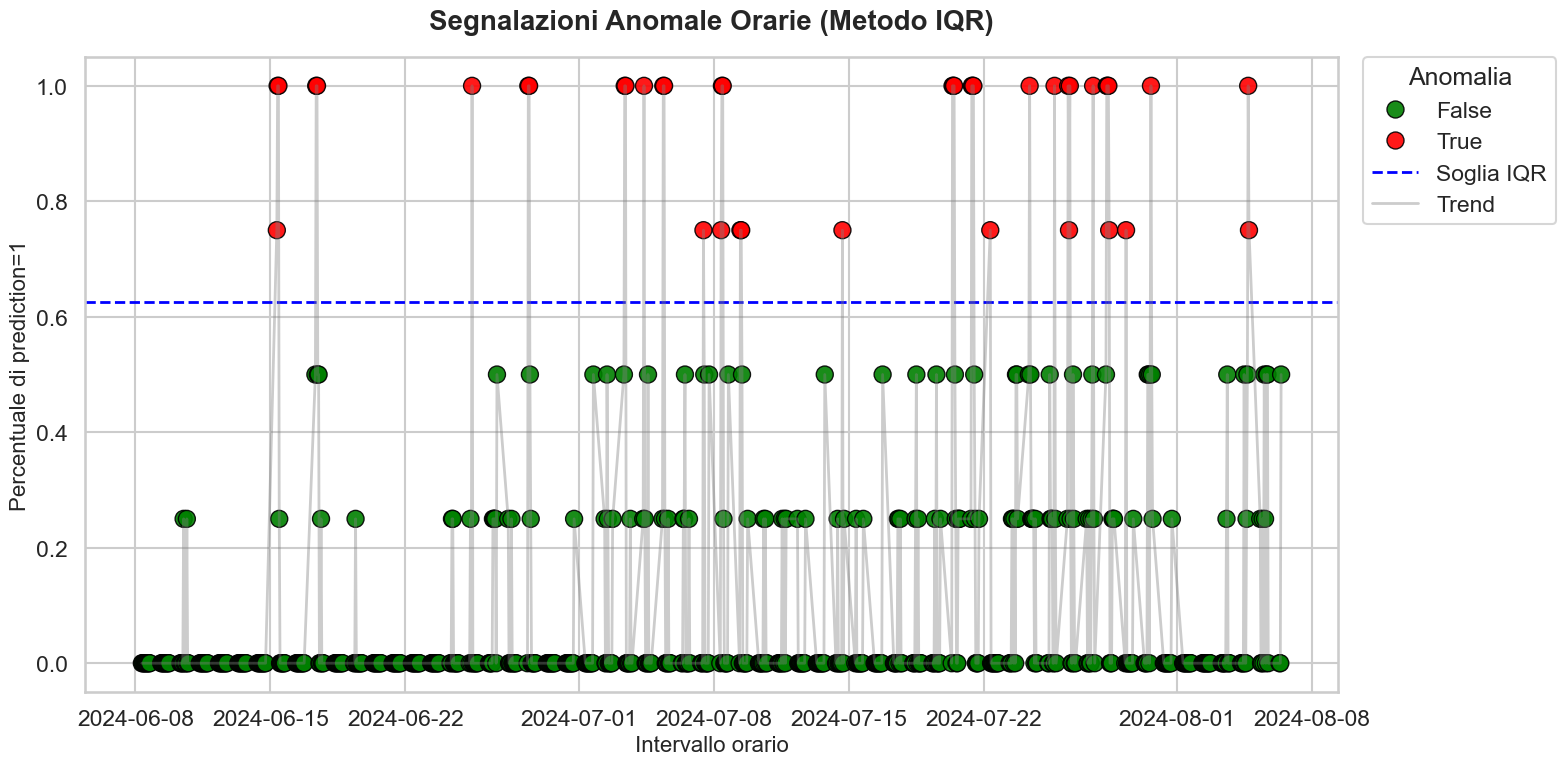


📍 Intervalli orari segnalati come anomali:

                     perc_positive
Date                              
2024-06-15 08:00:00           0.75
2024-06-15 09:00:00           1.00
2024-06-15 10:00:00           1.00
2024-06-17 09:00:00           1.00
2024-06-17 10:00:00           1.00
2024-06-25 11:00:00           1.00
2024-06-28 09:00:00           1.00
2024-06-28 10:00:00           1.00
2024-07-03 09:00:00           1.00
2024-07-03 10:00:00           1.00
2024-07-04 09:00:00           1.00
2024-07-05 09:00:00           1.00
2024-07-05 10:00:00           1.00
2024-07-07 11:00:00           0.75
2024-07-08 09:00:00           0.75
2024-07-08 10:00:00           1.00
2024-07-08 11:00:00           1.00
2024-07-09 09:00:00           0.75
2024-07-09 10:00:00           0.75
2024-07-14 16:00:00           0.75
2024-07-20 09:00:00           1.00
2024-07-20 10:00:00           1.00
2024-07-20 11:00:00           1.00
2024-07-21 09:00:00           1.00
2024-07-21 10:00:00           1.00
2024-07-21

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

res_df['Date'] = pd.to_datetime(res_df['Date'])

agg = res_df.groupby(pd.Grouper(key='Date', freq='1H')).agg(
    total_predictions=('prediction', 'count'),
    positive_predictions=('prediction', 'sum')
)

agg['perc_positive'] = agg['positive_predictions'] / agg['total_predictions']

Q1 = agg['perc_positive'].quantile(0.25)
Q3 = agg['perc_positive'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

agg['anomalous'] = agg['perc_positive'] > upper_bound

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(16, 8))

sns.scatterplot(
    x=agg.index,
    y='perc_positive',
    data=agg,
    hue='anomalous',
    palette={True: 'red', False: 'green'},
    s=150,
    alpha=0.9,
    edgecolor='black'
)

plt.axhline(upper_bound, color='blue', linestyle='--', linewidth=2, label='Soglia IQR')

sns.lineplot(
    x=agg.index,
    y='perc_positive',
    data=agg,
    color='gray',
    alpha=0.4,
    linewidth=2,
    label='Trend'
)

plt.title("Segnalazioni Anomale Orarie (Metodo IQR)", fontsize=20, weight='bold', pad=20)
plt.xlabel("Intervallo orario", fontsize=16)
plt.ylabel("Percentuale di prediction=1", fontsize=16)

plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    title="Anomalia",
    frameon=True
)

plt.tight_layout()
plt.show()

print("\n📍 Intervalli orari segnalati come anomali:\n")
print(agg[agg['anomalous']][['perc_positive']])
